In [5]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, MaxPooling3D, TimeDistributed, Dropout, Flatten, Dense
from sklearn.model_selection import train_test_split
import pandas as pd

# Constants
IMG_SIZE = 112  # Reduced image size to lessen memory usage
SEQUENCE_LENGTH = 15  # Increased sequence length to 15
BATCH_SIZE = 2  # Reduced batch size to prevent memory overload
EPOCHS = 50  # Number of epochs for training
NUM_CHANNELS = 3  # Number of color channels in each frame
seed_constant = 27  # Seed for reproducibility

# Set seeds for reproducibility
np.random.seed(seed_constant)
tf.random.set_seed(seed_constant)

# Function to load video frames
def load_video(path, max_frames=SEQUENCE_LENGTH, resize=(IMG_SIZE, IMG_SIZE)):
    if not os.path.exists(path):
        print(f"Video file {path} does not exist.")
        return np.array([])
    
    cap = cv2.VideoCapture(path)
    if not cap.isOpened():
        print(f"Error: Cannot open video file {path}")
        return np.array([])

    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]  # Convert BGR to RGB
            frames.append(frame)
            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    
    # Padding with zeros if less than max_frames
    while len(frames) < max_frames:
        frames.append(np.zeros((IMG_SIZE, IMG_SIZE, NUM_CHANNELS), dtype=np.uint8))
    
    return np.array(frames)

# Function to crop the center square of the frame
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

# Load the dataset from a CSV file
dataset_path = 'Data_logdf.csv'
dataset = pd.read_csv(dataset_path)

# Define the list of classes (unique tags)
CLASSES_LIST = np.unique(dataset["tag"])

# Encode labels
label_processor = tf.keras.layers.StringLookup(num_oov_indices=0, vocabulary=CLASSES_LIST)
print("Vocabulary:", label_processor.get_vocabulary())
labels = dataset["tag"].values
encoded_labels = label_processor(labels).numpy()

# Prepare video data
def prepare_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    encoded_labels = label_processor(labels).numpy()

    frame_data = np.zeros((num_samples, SEQUENCE_LENGTH, IMG_SIZE, IMG_SIZE, NUM_CHANNELS), dtype="float32")

    for idx, path in enumerate(video_paths):
        full_path = os.path.join(root_dir, path)
        frames = load_video(full_path)
        if frames.shape[0] == 0:
            continue
        print(f"Loaded {frames.shape[0]} frames for video {full_path}")
        frame_data[idx] = frames

    return frame_data, encoded_labels

Vocabulary: ['Baselayer_Preparation', 'Concreting', 'Mortar_Preparation', 'Plaster', 'Wall_Construction']


In [6]:
# Prepare the dataset
frame_data, labels = prepare_videos(dataset, "")

# Split data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(
    frame_data, labels, test_size=0.2, random_state=seed_constant
)

# Print the shapes of the data for verification
print(f"Train data shape: {train_data.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Test labels shape: {test_labels.shape}")

Loaded 15 frames for video Dataset/Mortar_Preparation/segment_1.mp4
Loaded 15 frames for video Dataset/Mortar_Preparation/segment_10.mp4
Loaded 15 frames for video Dataset/Mortar_Preparation/segment_100.mp4
Loaded 15 frames for video Dataset/Mortar_Preparation/segment_101.mp4
Loaded 15 frames for video Dataset/Mortar_Preparation/segment_102.mp4
Loaded 15 frames for video Dataset/Mortar_Preparation/segment_103.mp4
Loaded 15 frames for video Dataset/Mortar_Preparation/segment_104.mp4
Loaded 15 frames for video Dataset/Mortar_Preparation/segment_105.mp4
Loaded 15 frames for video Dataset/Mortar_Preparation/segment_106.mp4
Loaded 15 frames for video Dataset/Mortar_Preparation/segment_107.mp4
Loaded 15 frames for video Dataset/Mortar_Preparation/segment_108.mp4
Loaded 15 frames for video Dataset/Mortar_Preparation/segment_109.mp4
Loaded 15 frames for video Dataset/Mortar_Preparation/segment_11.mp4
Loaded 15 frames for video Dataset/Mortar_Preparation/segment_110.mp4
Loaded 15 frames for vid

[h264 @ 0x82591c0] mmco: unref short failure
[h264 @ 0x82591c0] mmco: unref short failure


Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_848.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_754.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_683.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_885.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_251.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_686.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_425.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_628.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_217.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_366.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_616.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_753.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_698.mp4
Loaded 15 frames for video Dataset/Baselayer_Prepar

[h264 @ 0x91fdb80] mmco: unref short failure
[h264 @ 0x91fdb80] mmco: unref short failure


Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_246.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_283.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_313.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_620.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_663.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_763.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_378.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_465.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_297.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_269.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_693.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_901.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_724.mp4
Loaded 15 frames for video Dataset/Baselayer_Prepar

[h264 @ 0x803ea80] mmco: unref short failure
[h264 @ 0x803ea80] mmco: unref short failure


Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_174.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_357.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_62.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_410.mp4


[h264 @ 0x91fd900] mmco: unref short failure


Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_242.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_276.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_450.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_793.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_388.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_339.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_767.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_786.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_629.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_831.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_317.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_688.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_37.mp4
Loaded 15 frames for video Dataset/Baselayer_Prepara

[h264 @ 0x91fe000] mmco: unref short failure


Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_23.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_300.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_415.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_691.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_185.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_856.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_236.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_287.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_267.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_439.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_367.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_452.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_912.mp4
Loaded 15 frames for video Dataset/Baselayer_Prepara

[h264 @ 0x905d180] mmco: unref short failure


Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_56.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_288.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_898.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_711.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_852.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_717.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_165.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_746.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_659.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_701.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_747.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_194.mp4
Loaded 15 frames for video Dataset/Baselayer_Preparation/segment_814.mp4
Loaded 15 frames for video Dataset/Baselayer_Prepara

[h264 @ 0x81e83c0] mmco: unref short failure
[h264 @ 0x81e83c0] mmco: unref short failure


Loaded 15 frames for video Dataset/Plaster/segment_1226.mp4
Loaded 15 frames for video Dataset/Plaster/segment_1335.mp4
Loaded 15 frames for video Dataset/Plaster/segment_1441.mp4
Loaded 15 frames for video Dataset/Plaster/segment_1004.mp4
Loaded 15 frames for video Dataset/Plaster/segment_974.mp4
Loaded 15 frames for video Dataset/Plaster/segment_1531.mp4
Loaded 15 frames for video Dataset/Plaster/segment_1034.mp4
Loaded 15 frames for video Dataset/Plaster/segment_1507.mp4
Loaded 15 frames for video Dataset/Plaster/segment_1458.mp4
Loaded 15 frames for video Dataset/Plaster/segment_1178.mp4
Loaded 15 frames for video Dataset/Plaster/segment_1563.mp4
Loaded 15 frames for video Dataset/Plaster/segment_1564.mp4
Loaded 15 frames for video Dataset/Plaster/segment_1505.mp4
Loaded 15 frames for video Dataset/Plaster/segment_978.mp4
Loaded 15 frames for video Dataset/Plaster/segment_1223.mp4
Loaded 15 frames for video Dataset/Plaster/segment_1392.mp4
Loaded 15 frames for video Dataset/Plaster

[h264 @ 0x8105500] mmco: unref short failure


Loaded 15 frames for video Dataset/Plaster/segment_997.mp4
Loaded 15 frames for video Dataset/Plaster/segment_1091.mp4
Loaded 15 frames for video Dataset/Plaster/segment_1435.mp4
Loaded 15 frames for video Dataset/Plaster/segment_1565.mp4
Loaded 15 frames for video Dataset/Plaster/segment_1201.mp4
Loaded 15 frames for video Dataset/Plaster/segment_1054.mp4
Loaded 15 frames for video Dataset/Plaster/segment_1520.mp4
Loaded 15 frames for video Dataset/Plaster/segment_1509.mp4
Loaded 15 frames for video Dataset/Plaster/segment_1324.mp4
Loaded 15 frames for video Dataset/Plaster/segment_1025.mp4
Loaded 15 frames for video Dataset/Plaster/segment_1154.mp4
Loaded 15 frames for video Dataset/Plaster/segment_1242.mp4
Loaded 15 frames for video Dataset/Plaster/segment_1578.mp4
Loaded 15 frames for video Dataset/Plaster/segment_1115.mp4
Loaded 15 frames for video Dataset/Plaster/segment_954.mp4
Loaded 15 frames for video Dataset/Plaster/segment_1068.mp4
Loaded 15 frames for video Dataset/Plaster

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 15, 110, 110,   │         1,024 │
│                                 │ 4)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 15, 55, 55, 4)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 15, 55, 55, 4)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 15, 53, 53, 8)  │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 15, 27, 27, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 15, 27, 27, 8)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 15, 25, 25, 14) │        11,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 15, 13, 13, 14) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 15, 13, 13, 14) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)      │ (None, 11, 11, 16)     │        17,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1936)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         9,685 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,685 (166.74 KB)

 Trainable params: 42,685 (166.74 KB)

 Non-trainable params: 0 (0.00 B)

2024-08-17 17:24:19.581897: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6331207680 exceeds 10% of free system memory.
2024-08-17 17:24:23.394858: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6331207680 exceeds 10% of free system memory.


Epoch 1/50


I0000 00:00:1723915470.564751    2076 service.cc:145] XLA service 0x860d080 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723915470.564915    2076 service.cc:153]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2024-08-17 17:24:30.749451: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-17 17:24:31.462317: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8900


   4/1402 ━━━━━━━━━━━━━━━━━━━━ 33s 24ms/step - accuracy: 0.0000e+00 - loss: 1.6439    

I0000 00:00:1723915527.127276    2076 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_slice_fusion_2', 24 bytes spill stores, 4 bytes spill loads

I0000 00:00:1723915527.177616    2076 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1402/1402 ━━━━━━━━━━━━━━━━━━━━ 98s 27ms/step - accuracy: 0.2779 - loss: 1.5443 - val_accuracy: 0.4829 - val_loss: 1.2991 - learning_rate: 1.0000e-04
Epoch 2/50
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 34s 24ms/step - accuracy: 0.5126 - loss: 1.2163 - val_accuracy: 0.5370 - val_loss: 1.1360 - learning_rate: 1.0000e-04
Epoch 3/50
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 34s 24ms/step - accuracy: 0.6006 - loss: 1.0547 - val_accuracy: 0.5812 - val_loss: 1.0406 - learning_rate: 1.0000e-04
Epoch 4/50
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 34s 24ms/step - accuracy: 0.6361 - loss: 0.9583 - val_accuracy: 0.6125 - val_loss: 0.9811 - learning_rate: 1.0000e-04
Epoch 5/50
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 34s 24ms/step - accuracy: 0.6676 - loss: 0.8895 - val_accuracy: 0.6368 - val_loss: 0.9349 - learning_rate: 1.0000e-04
Epoch 6/50
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 34s 24ms/step - accuracy: 0.7028 - loss: 0.8181 - val_accuracy: 0.6638 - val_loss: 0.9055 - learning_rate: 1.0000e-04
Epoch 7/50
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 34s 24ms/

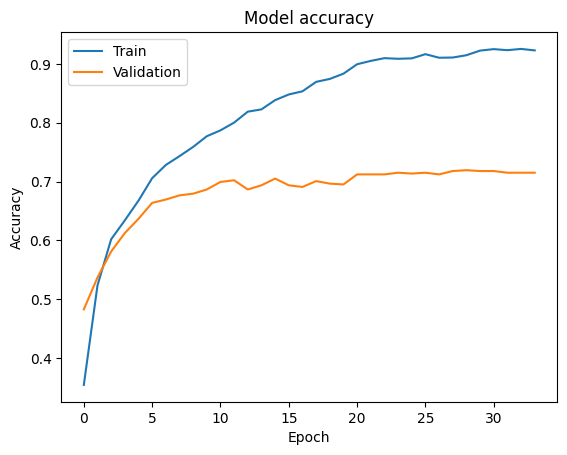

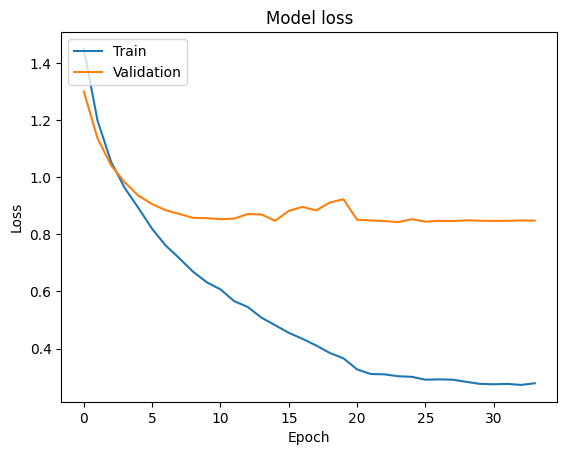

22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step
Classification Report:
                        precision    recall  f1-score   support

Baselayer_Preparation       0.59      0.59      0.59       144
           Concreting       0.70      0.80      0.74       143
   Mortar_Preparation       0.79      0.61      0.69       153
              Plaster       0.82      0.94      0.88       150
    Wall_Construction       0.65      0.61      0.63       112

             accuracy                           0.72       702
            macro avg       0.71      0.71      0.71       702
         weighted avg       0.72      0.72      0.71       702



In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, MaxPooling3D, TimeDistributed, Dropout, Flatten, Dense
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt



# Define the ConvLSTM model with reduced complexity
def create_convlstm_model():
    model = Sequential()

    # Model Architecture
    model.add(ConvLSTM2D(filters=4, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape=(SEQUENCE_LENGTH, IMG_SIZE, IMG_SIZE, 3)))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters=8, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters=14, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                         recurrent_dropout=0.2, return_sequences=False))

    model.add(Flatten())
    model.add(Dense(len(CLASSES_LIST), activation="softmax"))

    model.summary()
    return model

# Instantiate the ConvLSTM model
convlstm_model = create_convlstm_model()

# Compile the model
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
convlstm_model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=["accuracy"])

# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=5),
    tf.keras.callbacks.ModelCheckpoint('best_convlstm_model.keras', save_best_only=True)
]

# Train the model
convlstm_model_training_history = convlstm_model.fit(
    x=train_data,
    y=train_labels,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(test_data, test_labels),
    callbacks=callbacks
)

# Evaluate the model on the test set
test_loss, test_acc = convlstm_model.evaluate(test_data, test_labels)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Save the final model
convlstm_model.save('final_convlstm_model.keras')

# Plot training & validation accuracy values
plt.plot(convlstm_model_training_history.history['accuracy'])
plt.plot(convlstm_model_training_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(convlstm_model_training_history.history['loss'])
plt.plot(convlstm_model_training_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Generate predicted labels for the test data
test_pred_labels = convlstm_model.predict(test_data)
test_pred_labels = test_pred_labels.argmax(axis=1)

# Generate classification report
class_report = classification_report(test_labels, test_pred_labels, target_names=CLASSES_LIST)
print("Classification Report:\n", class_report)


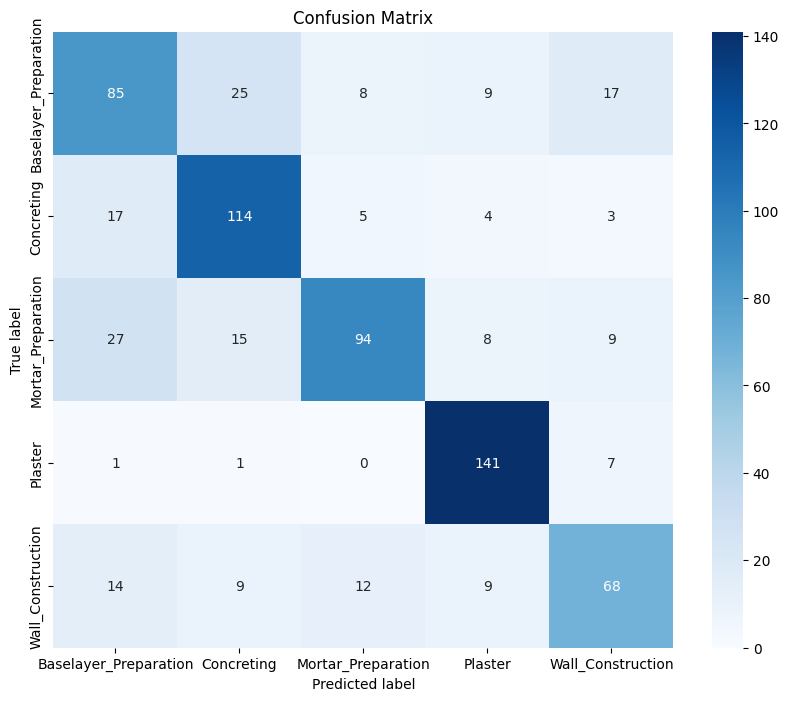

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

 
# Generate confusion matrix
conf_matrix = confusion_matrix(test_labels, test_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=CLASSES_LIST, yticklabels=CLASSES_LIST)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()